In [1]:
from transformers import PegasusXForConditionalGeneration, PegasusTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments, AutoTokenizer
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
class PegasusDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels['input_ids'][idx])  # torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels['input_ids'])  # len(self.labels)

In [ ]:
max_input_length = 8192
max_output_length = 512

In [4]:
def prepare_data(model_name,
                 train_texts, train_labels,
                 val_texts, val_labels,
                 test_texts, test_labels):
  """
  Prepare input data for model fine-tuning
  """
  tokenizer = AutoTokenizer.from_pretrained("google/pegasus-x-large")
  tokenizer.model_max_length = 4000

  prepare_val = False if val_texts is None or val_labels is None else True
  prepare_test = False if test_texts is None or test_labels is None else True

  def tokenize_data(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding='max_length',max_length = 4000)
    decodings = tokenizer(labels, truncation=True, padding='max_length',max_length = 512)
    dataset_tokenized = PegasusDataset(encodings, decodings)
    return dataset_tokenized

  train_dataset = tokenize_data(train_texts, train_labels)
  val_dataset = tokenize_data(val_texts, val_labels) if prepare_val else None
  test_dataset = tokenize_data(test_texts, test_labels) if prepare_test else None

  return train_dataset, val_dataset, test_dataset, tokenizer


In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    rouge = load_metric("rouge")

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(
        predictions=pred_str, references=label_str, rouge_types=["rouge2"]
    )["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

In [5]:
def prepare_fine_tuning(model_name, tokenizer, train_dataset, val_dataset, freeze_encoder=False, output_dir='./results'):
  """
  Prepare configurations and base model for fine-tuning
  """
  torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model = PegasusXForConditionalGeneration.from_pretrained("google/pegasus-x-base").to(torch_device)
  model.config.max_length = 512
  model.config.min_length = 100
  model.config.length_penalty = 2.0
  model.config.early_stopping = True
  model.config.no_repeat_ngram_size = 3
  print("val dataset length= ",len(val_dataset))

  if freeze_encoder:
    for param in model.model.encoder.parameters():
      param.requires_grad = False

  training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    fp16=True,
    output_dir="./",
    logging_steps=5,
    eval_steps=10,
    save_steps=10,
    save_total_limit=2,
    gradient_accumulation_steps=4,
    eval_accumulation_steps=1,
    num_train_epochs=5,
)
  trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,


    #compute_metrics=compute_metrics,
  )
  return trainer

In [6]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 

In [1]:
pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 5.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=33820c7e82308f5d41890697ba921a24b59c05bb8c533b697e4af0260aa7ec88
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
!pip install --upgrade pyarrow

In [6]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset, load_metric
from sklearn.model_selection import train_test_split
if __name__=='__main__':

  from datasets import load_dataset

  input_dir = '/content/drive/MyDrive/RA_Internship/PACSUM/DATASET_PACSUM/dataset/inputs'
  target_dir = '/content/drive/MyDrive/RA_Internship/PACSUM/DATASET_PACSUM/dataset/targets'
  data = {'input_text': [], 'target_text': []}
  input_files = glob.glob(os.path.join(input_dir, '*.txt'))

  for input_file in input_files:
        filename = os.path.basename(input_file)
        target_file = os.path.join(target_dir, filename)

        with open(input_file, 'r') as f:
            input_text = f.read()
        with open(target_file, 'r') as f:
            target_text = f.read()

        data['input_text'].append(input_text)
        data['target_text'].append(target_text)
  df = pd.DataFrame(data)
  train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
  eval_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

  train_dataset = Dataset.from_pandas(train_df)
  eval_dataset = Dataset.from_pandas(eval_df)
  test_dataset = Dataset.from_pandas(test_df)

 # print(test_dataset)


In [7]:
import accelerate

accelerate.__version__

'0.31.0'

In [ ]:
from transformers import logging

logging.set_verbosity_warning()

In [ ]:
print(len(train_dataset))

794


In [8]:
# use Pegasus Large model as base for fine-tuning
model_name = 'google/pegasus-x-base'
train_dataset, val_dataset, test_dataset, tokenizer = prepare_data(model_name, train_dataset['input_text'], train_dataset['target_text'], eval_dataset['input_text'], eval_dataset['target_text'], test_dataset['input_text'], test_dataset['target_text'])
trainer = prepare_fine_tuning(model_name, tokenizer, train_dataset,val_dataset)
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.60M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/262 [00:00<?, ?B/s]

val dataset length=  100


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'min_length': 100, 'early_stopping': True, 'num_beams': 8, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_eos_token_id': 1}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwarg

TrainOutput(global_step=500, training_loss=1.9869931230545044, metrics={'train_runtime': 3883.965, 'train_samples_per_second': 1.029, 'train_steps_per_second': 0.129, 'total_flos': 1.902131564544e+16, 'train_loss': 1.9869931230545044, 'epoch': 5.0})

In [9]:
trainer.state.log_history

[{'loss': 10.3923,
  'grad_norm': 56.86820602416992,
  'learning_rate': 4.9800000000000004e-05,
  'epoch': 0.05,
  'step': 5},
 {'loss': 8.6563,
  'grad_norm': 25.03250503540039,
  'learning_rate': 4.93e-05,
  'epoch': 0.1,
  'step': 10},
 {'eval_loss': 8.404562950134277,
  'eval_runtime': 14.6424,
  'eval_samples_per_second': 6.829,
  'eval_steps_per_second': 3.415,
  'epoch': 0.1,
  'step': 10},
 {'loss': 8.2626,
  'grad_norm': 9.512473106384277,
  'learning_rate': 4.88e-05,
  'epoch': 0.15,
  'step': 15},
 {'loss': 7.9827,
  'grad_norm': 12.38895034790039,
  'learning_rate': 4.83e-05,
  'epoch': 0.2,
  'step': 20},
 {'eval_loss': 7.516456127166748,
  'eval_runtime': 14.7041,
  'eval_samples_per_second': 6.801,
  'eval_steps_per_second': 3.4,
  'epoch': 0.2,
  'step': 20},
 {'loss': 7.6896,
  'grad_norm': 7.310408592224121,
  'learning_rate': 4.78e-05,
  'epoch': 0.25,
  'step': 25},
 {'loss': 7.4924,
  'grad_norm': 7.191237926483154,
  'learning_rate': 4.73e-05,
  'epoch': 0.3,
  's

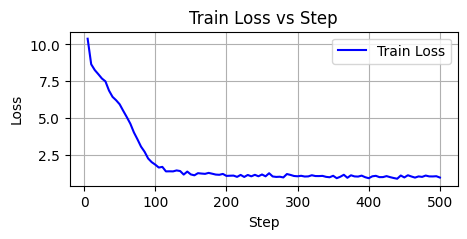

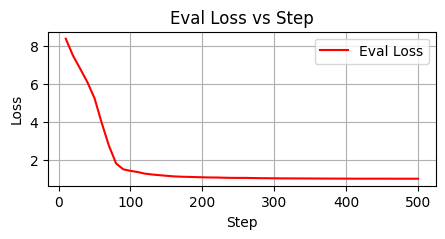

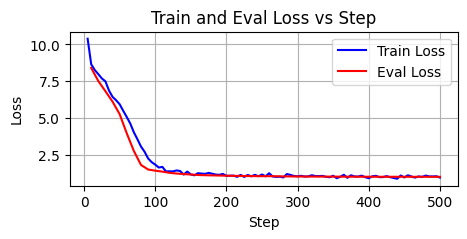

In [10]:
import pandas as pd
df=pd.DataFrame(trainer.state.log_history)
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is already defined, and train_loss and eval_loss are subsets of df
train_loss = df[['loss', 'step']]
eval_loss = df[['eval_loss', 'step']]

# Remove NaN rows in both dataframes
train_loss_clean = train_loss.dropna()
eval_loss_clean = eval_loss.dropna()

# Plotting the loss vs step for train_loss
plt.figure(figsize=(5, 2))
plt.plot(train_loss_clean['step'], train_loss_clean['loss'], label='Train Loss', color='blue')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Train Loss vs Step')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the loss vs step for eval_loss
plt.figure(figsize=(5, 2))
plt.plot(eval_loss_clean['step'], eval_loss_clean['eval_loss'], label='Eval Loss', color='red')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Eval Loss vs Step')
plt.legend()
plt.grid(True)
plt.show()

# Plotting both losses together
plt.figure(figsize=(5, 2))
plt.plot(train_loss_clean['step'], train_loss_clean['loss'], label='Train Loss', color='blue')
plt.plot(eval_loss_clean['step'], eval_loss_clean['eval_loss'], label='Eval Loss', color='red')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Train and Eval Loss vs Step')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!rm /content/drive/MyDrive/RA_Internship/HIPORANK/LED_model/LED\ Model\ with\ HIPORANK.gdoc

rm: cannot remove '/content/drive/MyDrive/RA_Internship/HIPORANK/LED_model/LED Model with HIPORANK.gdoc': No such file or directory


In [ ]:
trainer.args.output_dir = '/content/drive/MyDrive/RA_Internship/PACSUM'
trainer.push_to_hub()

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'min_length': 100, 'early_stopping': True, 'num_beams': 8, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_eos_token_id': 1}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwarg

In [ ]:

from transformers import pipeline

pipe = pipeline("text2text-generation", model="alwaysaditi/content")

config.json:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.60M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

In [ ]:
text = """as more and more decisions that have a significant ethical dimension are being outsourced to ai systems, it is important to have a definition of responsibility that can be applied to the decisions of ai systems, and that can be used by ai systems in the process of its decision-making . to meet the first condition, such a definition should require only a minimal notion of agency and instead focus on those aspects of responsibility that are readily applicable to (current) ai systems. to meet the second condition, such a definition should be formulated in a language that can be implemented into an ai system, so that it can integrate judgments of responsibility into its decision-making. this paper sets out to propose such a definition using the well-established framework of causal models .there exist different notions of moral responsibility that one might be interested in, and here we restrict attention to just one of them, namely responsibility for consequences, meaning the responsibility one has for a particular outcome that is the result of performing a particular action. this can be expressed more clearly by saying that the action caused the outcome, and therefore the first condition of concern here is the causal condition on responsibility . the past two decades have seen immense progress on offering formal definitions of actual causation by way of using causal models, and the definition here developed takes maximal advantage of this progress by comparing some recent proposals and choosing the one that correctly handles several complicated cases to be considered .our actions can cause all kinds of outcomes for which we are clearly not morally responsible: if a train crashes into a car that illegally crosses the railroad then the train conductor is not responsible for the car driver's death, if you turn on a light switch in a hotel room then you are not responsible if a short-circuit follows, etc.. the standard intuition that we have in such cases is that the agent "could not have known" that their action would cause the outcome. this is why definitions of responsibility also invoke an epistemic condition, stating roughly that the agent should have been able to foresee that they are performing an action which could result in them being responsible for the outcome .in addition to the causal and the epistemic conditions, it is standard to demand that responsibility also requires the fulfilment of a control condition (sometimes also called freedom condition), which expresses the fact that the agent had the right sort of control whilst performing their action . due to its close connection to issues of free will and determinism, this condition is heavily debated within philosophy. within the context of (current) ai systems, however, the control condition can take on a more mundane form: any action that was a result of the correct operation of its program can be viewed as being under the ai's control. therefore i simply take there to be a specific action variable that ranges over a set of possible actions, and assume that whenever the ai system is running successfully it has control over the value that this variable takes.my approach proceeds along the same lines as that of braham and van hees (bvh) . they offer the most influential formalization of moral responsibility that incorporates both the causal and the epistemic conditions, and therefore their work forms an appropriate point of comparison. although i agree with the spirit of their approach, i disagree with its formulation. first, their causal condition defines causation as being a necessary element of a sufficient set (ness). however, their use of game-theory instead of causal models results in an overly simplistic view of ness-causation that cannot handle indirect causation. therefore i first formulate their definition using causal models, and then show how to modify it so that it can overcome this limitation. second, i disagree with the particulars of both their causal and their epistemic conditions. i argue for replacing the ness definition of causation with my recently developed counterfactual ness (cness) definition . their epistemic condition states that the agent should minimize the probability of causation. i argue for giving that condition a secondary role: minimizing the probability of causing the outcome is subservient to minimizing the probability of the outcome simpliciter. i analyze several examples to illustrate the superiority of my conditions.more recently, halpern & kleiman-weiner (hk) used causal models to propose definitions of several concepts that are closely related to moral responsibility. although they do not explicitly define moral responsibility, they do suggest using the modified halpern & pearl (hp) definition of causation for the causal condition . the hp definition correctly handles most of the counterexamples to the ness definition here presented, but i discuss two types of example for which it fails (whereas the cness definition does not). hk also offer a definition of "degree of blameworthiness" that for all intents and purposes is very similar to an epistemic condition: it measures the extent to which the agent minimized the probability of the outcome. i present a case in which the epistemic conditions of bvh and hk conflict in order to argue that a more elaborate epistemic condition is required. my epistemic condition combines that of hk with that of bvh by demanding that an agent minimizes the probability of the outcome, but if possible also minimizes the probability of causation.there exist different notions of moral responsibility that one might be interested in, and here we restrict attention to just one of them, namely responsibility for consequences, meaning the responsibility one has for a particular outcome that is the result of performing a particular action. this is why definitions of responsibility also invoke an epistemic condition, stating roughly that the agent should have been able to foresee that they are performing an action which could result in them being responsible for the outcome.in addition to the causal and the epistemic conditions, it is standard to demand that responsibility also requires the fulfilment of a control condition (sometimes also called freedom condition), which expresses the fact that the agent had the right sort of control whilst performing their action. hk also offer a definition of "degree of blameworthiness" that for all intents and purposes is very similar to an epistemic condition: it measures the extent to which the agent minimized the probability of the outcome. my epistemic condition combines that of hk with that of bvh by demanding that an agent minimizes the probability of the outcome, but if possible also minimizes the probability of causation.informally, the bvh definition of responsibility requires that an agent's action directly ness-caused the outcome, and that the agent believes they failed to minimize the probability of their action causing the outcome.in addition to disagreeing about the definition of causation, the hk definition also disagrees with the bvh definition about the epistemic condition: rather than requiring that the agent failed to minimize the probability of causing the outcome, the hk definition focuses on the agent failing to minimize the probability of the outcome simpliciter.note that both hk and bvh's epistemic condition satisfy our responsibility schema: an agent who believes that they failed to minimize a probability that they could have minimized, thereby also believes that they could have avoided satisfying the respective epistemic condition.) note that in case s 1 = 1, then s 2 = 0 would result in the outcome being overdetermined, and thus although the latter action would also be a cause of the outcome, it does nothing to contribute to the probability of the outcome occurring.) thus the action of assassin 1 had no effect on the probability of the outcome, and would thus not be responsible for victim's death according to hk's definition. among all actions that minimize the probability of the outcome, we take one that minimizes the probability of causing the outcome, and then take a weighted sum of both causal strength measures for that action (where the second measure is ignored if it is negative).although both assassins are responsible according to my definition, it is easy to see that assassin 1 is responsible to a higher degree: the measures of actual causation are identical for both and so are their respective probabilities of the outcome occurring given that they shoot (namely 1), but assassin 1 's probability of the outcome occurring given that they do not shoot is far lower, and thus 7 cs ass1 e. that is also the verdict of my degree of blameworthiness: in this case, the atypical agent can reasonably expect the outcome to depend on them performing the action whereas the typical agent can reasonably expect that their action has little impact, which translates into a larger measure of causal strength (both cs e and cs ac ) for the former.based on a comparison with the work of bvh and hk, i have offered a novel formal definition of moral responsibility that is particularly suited for ai systems by filling in the causal and the 6 surprisingly, to my knowledge this rather obvious measure of causal strength has been overlooked so far in the literature. i used contrasting examples to argue in favor of the counterfactual ness definition of causation over the ness and the hp definition, and in favor of a nuanced epistemic condition that combines the two conditions of bvh and hk."""

In [ ]:
summary = pipe(text, max_length=512, min_length=100, do_sample=False)

In [ ]:
generated_summary = summary[0]['generated_text']
print(generated_summary)

however however, their use of game theory instead of causal models results in an overly simplistic view of ness-causation that cannot handle indirect causation. therefore i first formulate their definition using causal models, and then show how to modify it so that it can overcome this limitation. I agree with the spirit of their approach. firstly, their definition of moral responsibility is very similar to an epistemic condition: it measures the extent to which the agent minimized the probability of the outcome. second, they offer a definition of "degree of blameworthiness" that for all intents and purposes is very similiar to an "estructive condition," which expresses the fact that the agent had the right sort of control whilst performing their action. third, they present a case in which the epistemic conditions of bvh and hk conflict, in order to argue that a more elaborate epistemic condition is required that is required. they present two types of example for which it fails (wherea

In [ ]:
target_text = """as more and more decisions that have a significant ethical dimension are being outsourced to ai systems, it is important to have a definition of moral responsibility that can be applied to ai systems. moral responsibility for an outcome of an agent who performs some action is commonly taken to involve both a causal condition and an epistemic condition: the action should cause the outcome, and the agent should have been aware -in some form or other -of the possible moral consequences of their action. this paper presents a formal definition of both conditions within the framework of causal models. i compare my approach to the existing approaches of braham and van hees (bvh) and of halpern and kleiman-weiner (hk). i then generalize my definition into a degree of responsibility. """

In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=68f68e8de6d1379edd13539d414698a91cd28a38bd1c1e432853b5e3aaa19b21
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
from evaluate import load
# Load the ROUGE metric
import evaluate
rouge = evaluate.load('rouge')

In [ ]:
candidates = [generated_summary]

references = [[target_text]
             ]
results = rouge.compute(predictions=candidates, references=references)
print(results)

{'rouge1': 0.42, 'rouge2': 0.10738255033557047, 'rougeL': 0.2, 'rougeLsum': 0.2}
